## Testing QuakeFlow on Endeavour continuous data

In [25]:
from collections import defaultdict
import numpy as np
import pandas as pd
import time
import requests
import json
import obspy
from obspy.clients.fdsn import Client
import geopandas as gpd
from datetime import timedelta
from obspy.core import UTCDateTime
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Now let's get a list of the stations to pull data from (all the stations operating that month)

This will be in the form networkcode.stationcode.locationcode.channelbase

#### Note: let's throw out the pressure channels (code HDH)

#### Let's get the station information for those stations from IRIS


In [8]:
network = 'NV'
channel = 'EHE,EHN,EHZ,HHZ,HHN,HHE'
station = 'KEMF,KEMO,NCHR,ENWF,ENHR'
starttime = UTCDateTime("2018-02-07T12:15:00")


sta_metadata = Client("iris").get_stations(starttime = starttime, endtime  = starttime + timedelta(weeks=4),network =network,channel=channel,station=station,level='response',location='')
    
print(sta_metadata)

Inventory created at 2022-01-18T22:15:25.569000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.48
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2018-02-07...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NV
		Stations (4):
			NV.ENWF (Endeavour West Flank)
			NV.KEMF (Endeavour Main Field)
			NV.KEMO (Mothra Field)
			NV.NCHR (High Rise Field)
		Channels (12):
			NV.ENWF..HHZ, NV.ENWF..HHN, NV.ENWF..HHE, NV.KEMF..EHZ, 
			NV.KEMF..EHN, NV.KEMF..EHE, NV.KEMO..EHZ, NV.KEMO..EHN, 
			NV.KEMO..EHE, NV.NCHR..EHZ, NV.NCHR..EHN, NV.NCHR..EHE


#### Let's turn it into a more useful dataframe...

In [9]:
station_locs = defaultdict(dict)
for network in sta_metadata:
    for station in network:
        for chn in station:
            sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
            if sid in station_locs:
                station_locs[sid]["component"] += f",{chn.code[-1]}"
                station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
            else:
                component = f"{chn.code[-1]}"
                response = f"{chn.response.instrument_sensitivity.value:.2f}"
                dtype = chn.response.instrument_sensitivity.input_units.lower()
                tmp_dict = {}
                tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = (
                    chn.longitude,
                    chn.latitude,
                    chn.elevation,
                )
                tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                station_locs[sid] = tmp_dict

station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
station_locs["id"] = station_locs.index

In [11]:
# Interactive visualization with geopandas geodataframe
gf = gpd.GeoDataFrame(station_locs.copy(), 
                      geometry=gpd.points_from_xy(station_locs.longitude, station_locs.latitude),
                      crs=4326,
                     )

gf.to_file('endeavour_stations.json', driver='GeoJSON')

gf.explore()

### Now let's download some data!

In [12]:
client = Client("iris")
interval = 30 #s
# interval = 3600 #s

# for event in events:
def download(starttime, stations):
    '''
    For a given 'event' and 'stations' list download 30 second waveforms w/ 100Hz samping rate
    
    Output: obspy miniseed stream
    '''

    endtime = starttime + interval

    max_retry = 10
    stream = obspy.Stream()
    num_sta = 0
    for network in stations:
        for station in network:
            # print(f"********{network.code}.{station.code}********")
            retry = 0
            while retry < max_retry:
                try:
                    tmp = client.get_waveforms(
                        network.code, station.code, "*", channel, starttime, endtime
                    )
                    for trace in tmp:
                        if trace.stats.sampling_rate != 100:
                            # print(trace)
                            trace = trace.interpolate(100, method="linear")
                    #      trace = trace.detrend("spline", order=2, dspline=5*trace.stats.sampling_rate)
                    #      stream.append(trace)
                    stream += tmp
                    num_sta += len(tmp)
                    break
                except Exception as err:
                    print("Error {}.{}: {}".format(network.code, station.code, err))
                    message = "No data available for request."
                    if str(err)[: len(message)] == message:
                        break
                    retry += 1
                    time.sleep(5)
                    continue
            if retry == max_retry:
                print(f"{fname}: MAX {max_retry} retries reached : {network.code}.{station.code}")
            
    # stream.attach_response(stations)
    # stream = stream.remove_sensitivity()
    return stream

In [13]:
def convert_mseed(mseed, station_locs):
    try:
        mseed = mseed.detrend("spline", order=2, dspline=5 * mseed[0].stats.sampling_rate)
    except:
        logging.error(f"Error: spline detrend failed at file {fname}")
        mseed = mseed.detrend("demean")
    mseed = mseed.merge(fill_value=0)
    starttime = min([st.stats.starttime for st in mseed])
    endtime = max([st.stats.endtime for st in mseed])
    mseed = mseed.trim(starttime, endtime, pad=True, fill_value=0)

    for i in range(len(mseed)):
        if mseed[i].stats.sampling_rate != sampling_rate:
            logging.warning(
                f"Resampling {mseed[i].id} from {mseed[i].stats.sampling_rate} to {sampling_rate} Hz"
            )
            mseed[i] = mseed[i].interpolate(sampling_rate, method="linear")

    order = ['3', '2', '1', 'E', 'N', 'Z']
    order = {key: i for i, key in enumerate(order)}
    comp2idx = {"3": 0, "2": 1, "1": 2, "E": 0, "N": 1, "Z": 2}

    nsta = len(station_locs)
    nt = max(len(mseed[i].data) for i in range(len(mseed)))
    data = []
    station_id = []
    t0 = []
    for i in range(nsta):
        trace_data = np.zeros([nt, n_channel], dtype=dtype)
        empty_station = True
        # sta = station_locs.iloc[i]["station"]
        sta = station_locs.index[i]
        comp = station_locs.iloc[i]["component"].split(",")
        if remove_resp:
            resp = station_locs.iloc[i]["response"].split(",")
            # resp = station_locs.iloc[i]["response"]
        for j, c in enumerate(sorted(comp, key=lambda x: order[x[-1]])):

            resp_j = float(resp[j])
            
            
            if len(comp) != 3:  ## less than 3 component
                j = comp2idx[c]

            if len(mseed.select(id=sta + c)) == 0:
                print(f"Empty trace: {sta+c} {starttime}")
                continue
            else:
                empty_station = False

            tmp = mseed.select(id=sta + c)[0].data.astype(dtype)
            trace_data[: len(tmp), j] = tmp[:nt]

            if station_locs.iloc[i]["unit"] == "m/s**2":
                tmp = mseed.select(id=sta + c)[0]
                tmp = tmp.integrate()
                tmp = tmp.filter("highpass", freq=1.0)
                tmp = tmp.data.astype(dtype)
                trace_data[: len(tmp), j] = tmp[:nt]
            elif station_locs.iloc[i]["unit"] == "m/s":
                tmp = mseed.select(id=sta + c)[0].data.astype(dtype)
                trace_data[: len(tmp), j] = tmp[:nt]
            else:
                print(
                    f"Error in {station_locs.iloc[i]['station']}\n{station_locs.iloc[i]['unit']} should be m/s**2 or m/s!"
                )
            
            if remove_resp:
                trace_data[:, j] /= resp_j
                
        if not empty_station:
            data.append(trace_data)
            station_id.append(sta)
            t0.append(starttime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3])

    data = np.stack(data)

    meta = {"data": data, "t0": t0, "station_id": station_id, "fname": station_id}
    
    
    return meta

Loop over the call to the download() function. It just takes the sta_metadata object and a starttime, in UTCdatetime.

In [17]:
# Let's just start with an hour

# INITIALIZE WITH PARAMETERS
base_time = starttime-30
sampling_rate = 100
n_channel = 3
dtype = "float32"
amplitude = True
remove_resp = True
PHASENET_API_URL = "http://phasenet.quakeflow.com"
config = {}
config["xlim_degree"] = [-129.5,-128]
config["ylim_degree"] = [47,49]
stations_json = station_locs.to_dict(orient="records")
config_gamma = {'xlim_degree': config["xlim_degree"], 
                'ylim_degree': config["ylim_degree"],
                'z(km)': [0,15]}

starttime = UTCDateTime("2018-01-14T18:36:00")
phasenet_picks=[]
for i in range(30):
    print(i)
    # Download 30 s data from IRIS:
    mseed = download(starttime+(interval*i),sta_metadata)
    # Convert to numpy arrays:
    meta = convert_mseed(mseed,station_locs)
    batch = 4
    for j in range(0,len(meta['station_id']), batch):
        req = {"id": meta['station_id'][j:j+batch],
        "timestamp": meta["t0"][j:j+batch],
        "vec": meta["data"][j:j+batch].tolist()}

        resp = requests.post(f'{PHASENET_API_URL}/predict', json=req)
        phasenet_picks.extend(resp.json())
        
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


#### Take the phasenet picks you just got and run them through GAMMA to associate.

In [18]:
GAMMA_API_URL = "http://gamma.quakeflow.com"
result = requests.post(f'{GAMMA_API_URL}/predict', json= {"picks": phasenet_picks, 
                                                          "stations": stations_json,
                                                           "config": config_gamma})

result = result.json()
catalog_gamma = result["catalog"]
picks_gamma = result["picks"]
print("GaMMA catalog:")
dfC = pd.DataFrame(catalog_gamma)[["time", "latitude", "longitude", "depth(m)", "magnitude", "covariance"]]
display(dfC)
print("GaMMA association:")
dfA = pd.DataFrame(picks_gamma)

GaMMA catalog:


KeyError: "None of [Index(['time', 'latitude', 'longitude', 'depth(m)', 'magnitude', 'covariance'], dtype='object')] are in the [columns]"

### Now we save the QuakeFlow results to a json file:

In [ ]:
save_file = 'endeavour_example'

with open(save_file+'.json', 'w') as f:
    json.dump(result, f)

#### Look at the picks!

In [23]:
picks_gamma = result["picks"]
new_picks = pd.DataFrame(picks_gamma)
new_picks.head()

,id,timestamp,prob,amp,type,event_idx,prob_gmma
0,NV.ENWF..HH,2018-01-14T18:36:02.860,0.380477,1.123893e-05,p,-1,-1
1,NV.ENWF..HH,2018-01-14T18:36:07.500,0.407652,1.123893e-05,s,-1,-1
2,NV.KEMF..EH,2018-01-14T18:36:02.920,0.582039,9.753157e-07,p,-1,-1
3,NV.KEMF..EH,2018-01-14T18:36:07.330,0.711251,9.753157e-07,s,-1,-1
4,NV.KEMO..EH,2018-01-14T18:36:02.470,0.961800,1.798209e-06,p,-1,-1


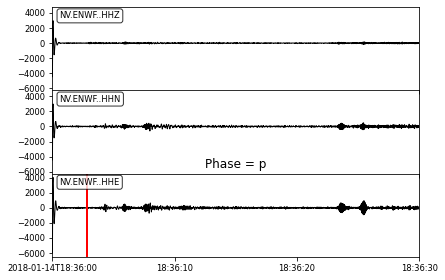

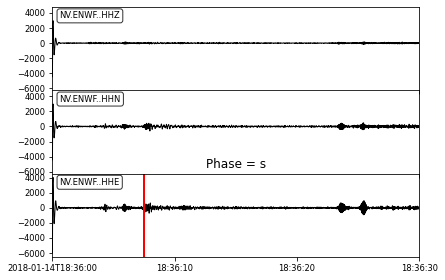

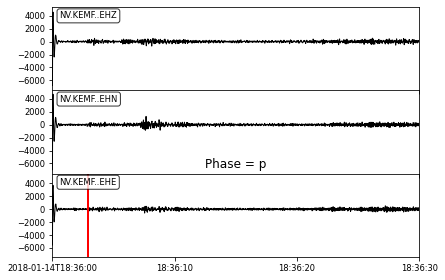

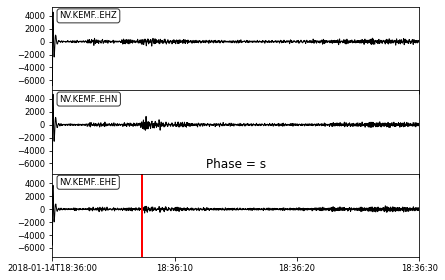

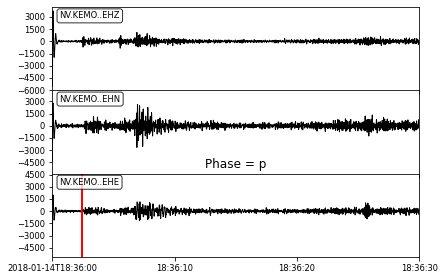

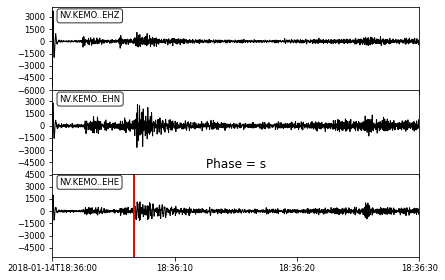

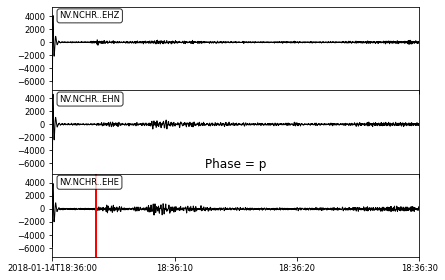

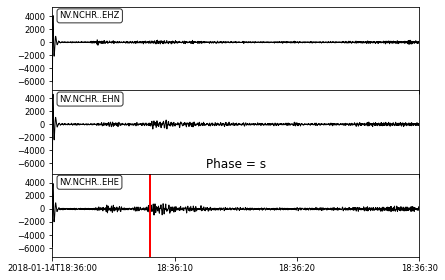

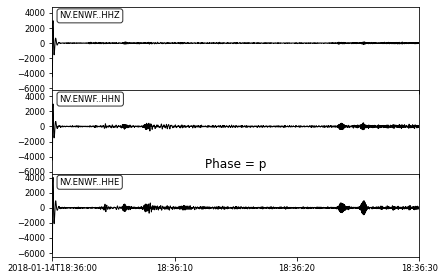

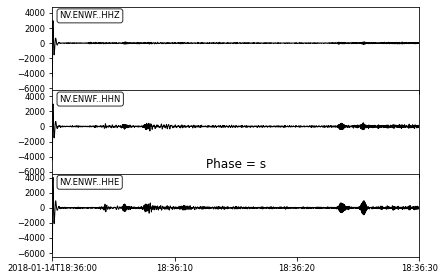

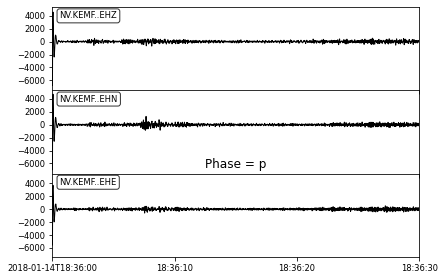

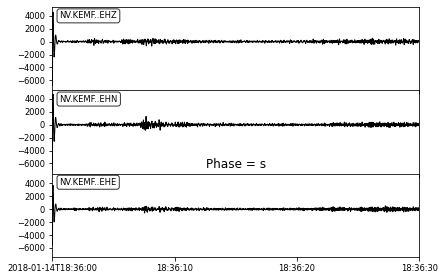

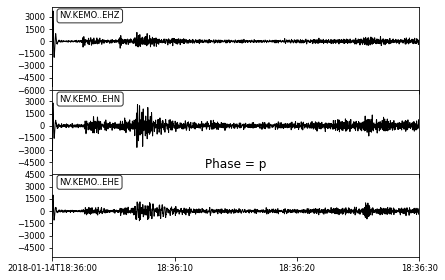

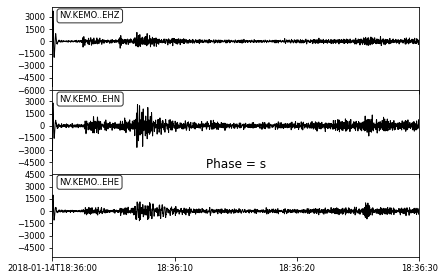

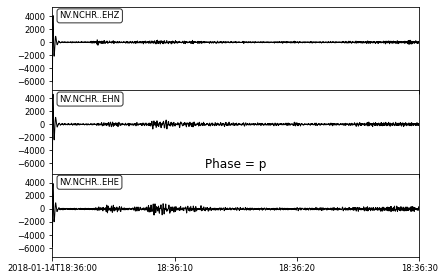

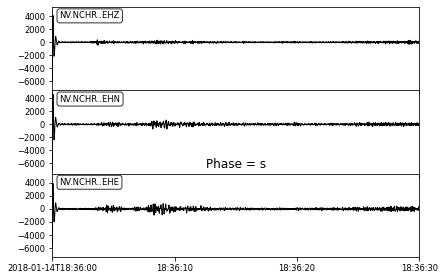

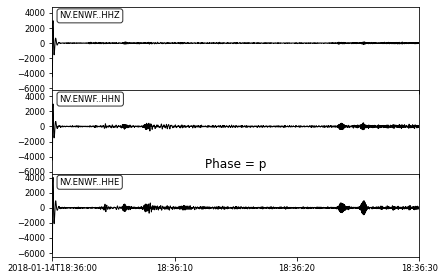

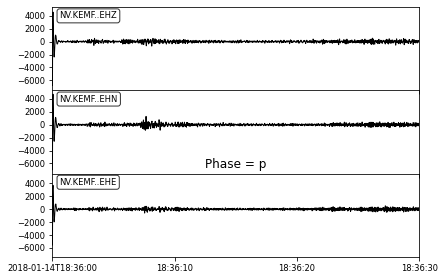

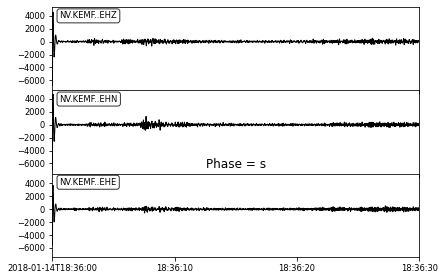

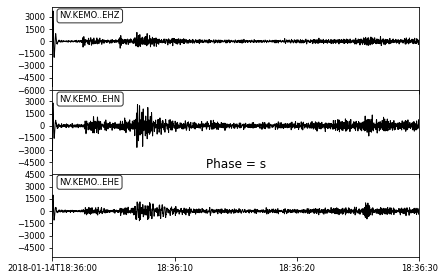

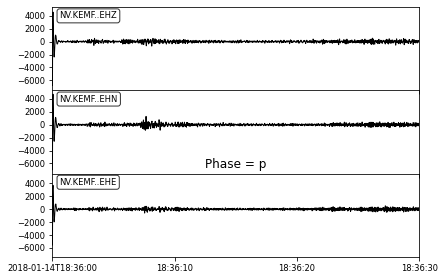

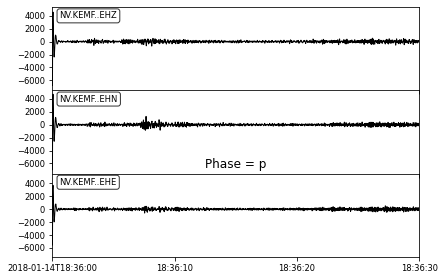

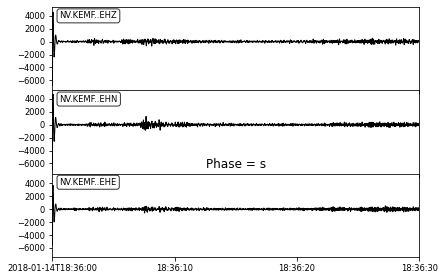

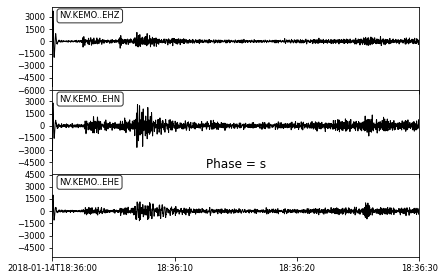

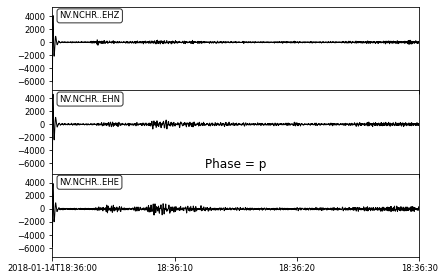

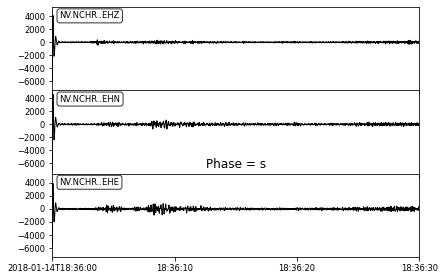

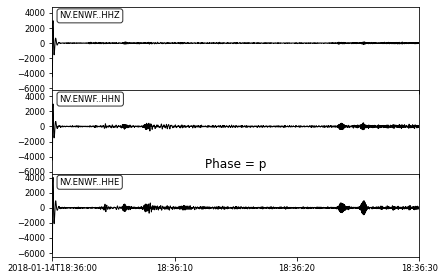

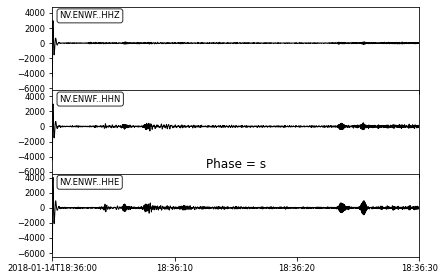

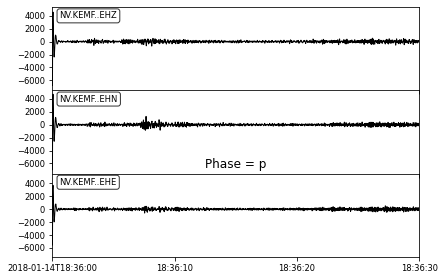

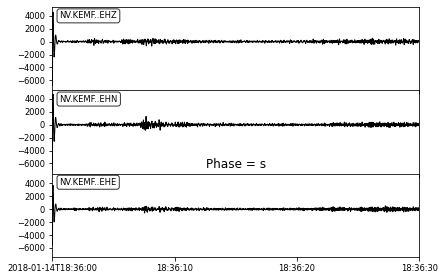

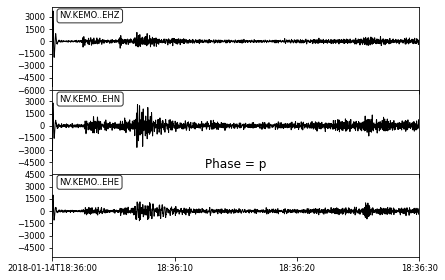

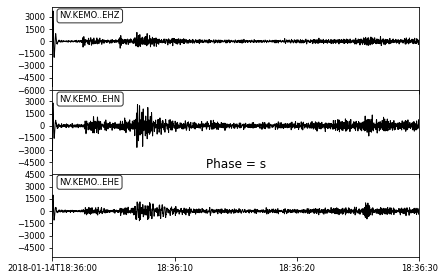

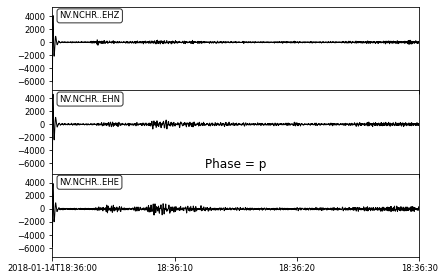

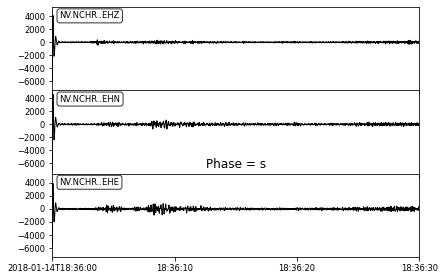

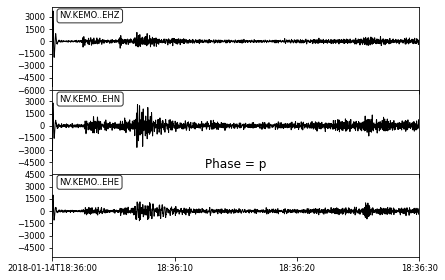

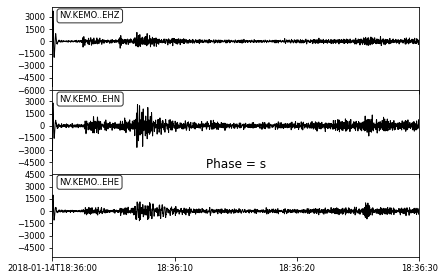

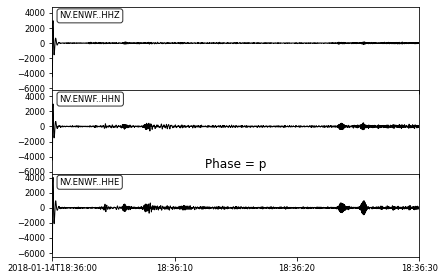

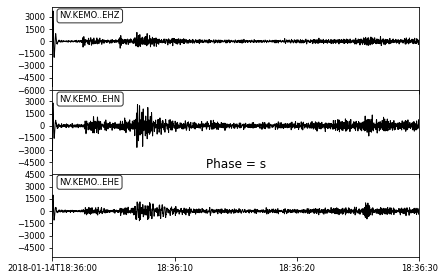

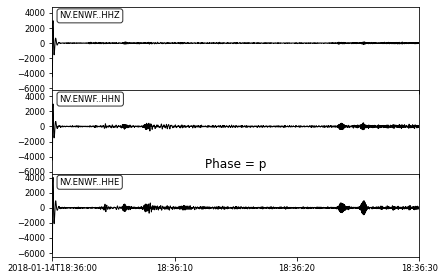

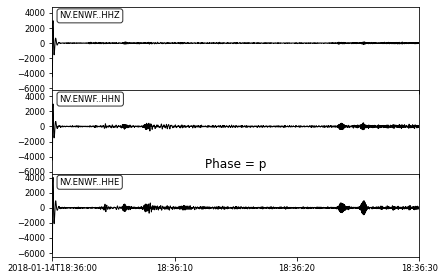

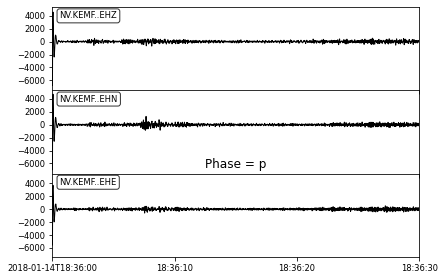

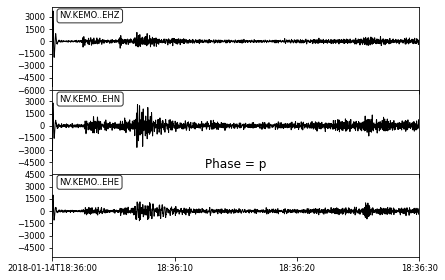

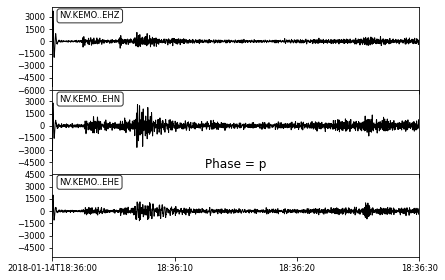

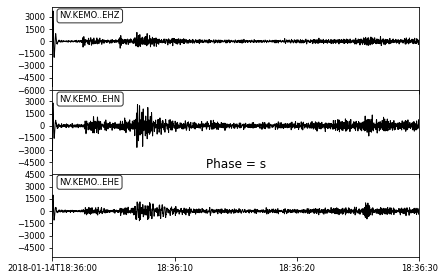

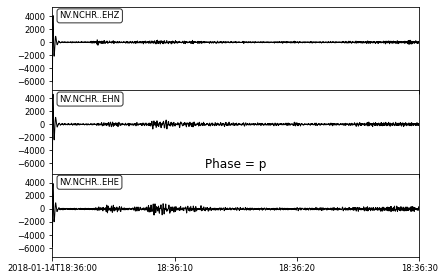

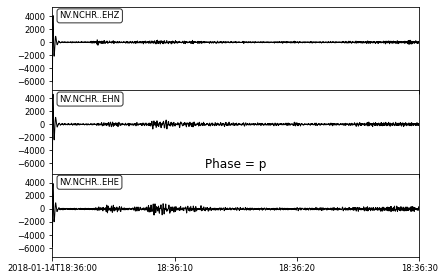

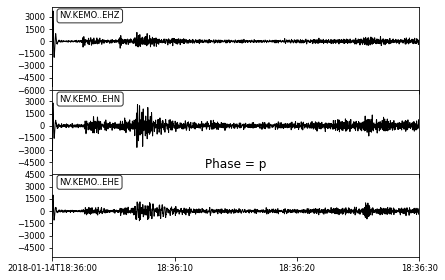

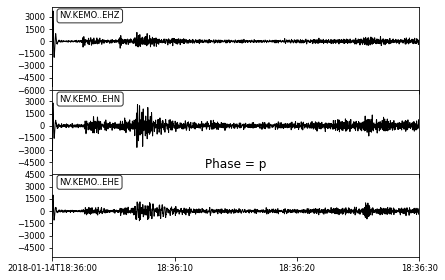

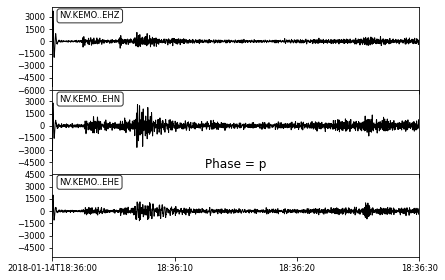

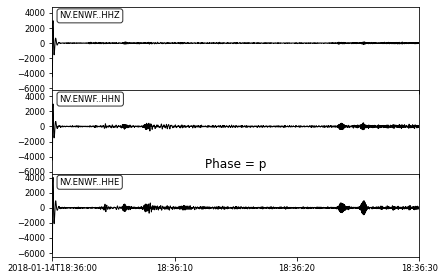

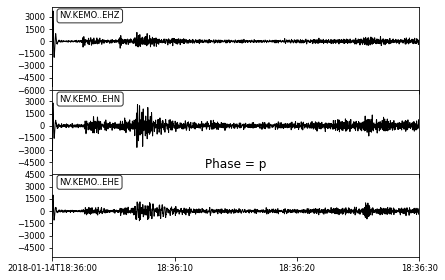

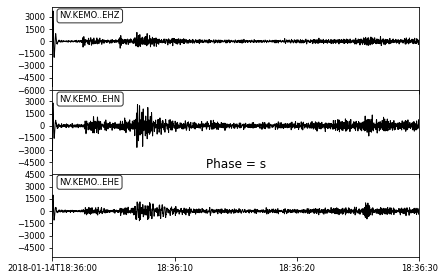

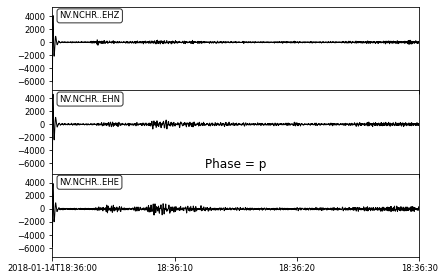

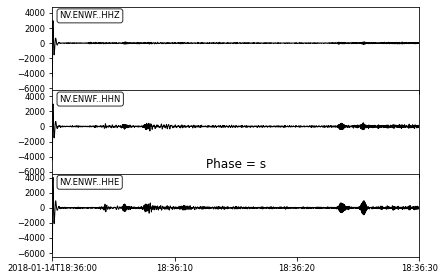

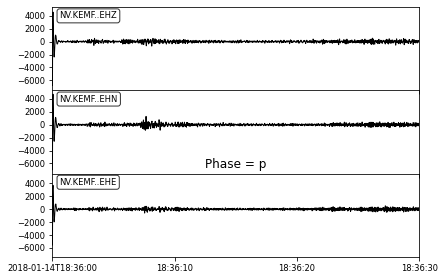

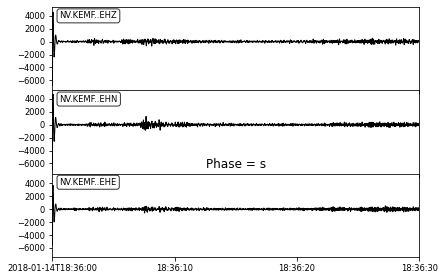

KeyboardInterrupt: 

In [26]:
new_picks['timestamp'] = [obspy.UTCDateTime(t) for t in new_picks['timestamp']]

client = Client("iris")
interval = 30 #s
endtime = starttime + interval
stream = obspy.Stream()
for i in range(len(new_picks)):
    txt=new_picks.iloc[i]['id']
    trace_info=txt.split('.')
    # Read in waveform:
    st = client.get_waveforms(trace_info[0],trace_info[1],trace_info[2],trace_info[3]+'*', starttime, endtime,attach_response=True)
    # Do some waveform processing:
    # st.remove_response()
    # st = st.detrend("spline", order=2, dspline=5 * st[0].stats.sampling_rate)
    # st = st.filter("highpass", freq=1.0)
    st = st.filter("bandpass",freqmin=4,freqmax=35)
    
    %matplotlib inline
    fig = plt.figure()
    st.plot(fig = fig,starttime=starttime,endtime=endtime) 
    plt.axvline(x=new_picks.iloc[i]['timestamp'],linewidth=2, color='r')
    plt.title('Phase = '+new_picks.iloc[i]['type'])
    plt.show()